In [224]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import copy
import collections
from scipy.ndimage.filters import gaussian_filter1d

In [225]:
def loadData():
    print("--loading data--")
    with open("pickled_mnist.pkl", "br") as fh:
        data = pickle.load(fh)
    imgs_train = data[0]
    imgs_test = data[1]
    train_labels = data[2]
    test_labels = data[3]
    train_labels_one_hot = data[4]
    test_labels_one_hot = data[5]
    print("--data loaded--")
    return imgs_train, imgs_test, train_labels, test_labels, train_labels_one_hot, test_labels_one_hot

In [233]:
def generate_batch(inputs, targets, labels, batch_size):
    rand_inds = np.random.randint(0, len(targets), batch_size)
    inputs_batch = inputs[rand_inds]
    targets_batch = targets[rand_inds]
    labels_batch = labels[rand_inds]
    return inputs_batch, targets_batch, labels_batch
    

def sigmoid(a):
    siga = 1/(1 + np.exp(-a))
    return siga
    

class nn_one_layer():
    def __init__(self, input_size, hidden_size, output_size):
        #define the input/output weights W1, W2
        self.W1 = 0.1 * np.random.randn(input_size, hidden_size)
        self.W2 = 0.1 * np.random.randn(hidden_size, output_size)
        
        self.sig = sigmoid
    
    def forward(self, u):
        z = np.matmul(u, self.W1)
        h = self.sig(z)
        v = np.matmul(h, self.W2)       
        return v, h, z


#loss function as defined above
def loss_mse(preds, targets):
    loss = np.sum((preds - targets)**2)
    return 0.5 * loss

#derivative of loss function with respect to predictions
def loss_deriv(preds, targets):
    dL_dPred = preds - targets
    return dL_dPred


#derivative of the sigmoid function
def sigmoid_prime(a):
    dsigmoid_da = sigmoid(a)*(1-sigmoid(a))
    return dsigmoid_da

#compute the derivative of the loss wrt network weights W1 and W2
#dL_dPred is (precomputed) derivative of loss wrt network prediction
#X is (batch) input to network, H is (batch) activity at hidden layer
def backprop(W1, W2, dL_dPred, U, H, Z):
    
    dL_dW2 = np.matmul(H.T, dL_dPred)
    dL_dH = np.matmul(dL_dPred, W2.T)
    dL_dZ = np.multiply(sigmoid_prime(Z), dL_dH)
    dL_dW1 = np.matmul(U.T, dL_dZ)
    
    return dL_dW1, dL_dW2

# Function for computing the entropy within the hidden layer of the network.
def computeHiddenState(H, batch_size, hidden_size):
    hiddenState = copy.deepcopy(H)
    strings = []
    threshold = np.sum(hiddenState, axis=1)/hidden_size
    threshold = np.stack((threshold,) * hidden_size, axis=-1)
    hiddenState[hiddenState > threshold] = 1
    hiddenState[hiddenState < threshold] = 0
    for i in range(batch_size):
       string = (np.array2string(hiddenState[i], separator='')).replace('[','').replace(']','').replace('.','')
       strings.append(string)
    return strings
    

#train the provided network with one batch according to the dataset
#return the loss for the batch
def train_one_batch(nn, imgs, targets, labels, batch_size, lr, hidden_size):
    inputs, targs, labls = generate_batch(imgs, targets, labels, batch_size)
    preds, H, Z = nn.forward(inputs)
    loss = loss_mse(preds, targs)
    
    dL_dPred = loss_deriv(preds, targs)
    dL_dW1, dL_dW2 = backprop(nn.W1, nn.W2, dL_dPred, U=inputs, H=H, Z=Z)

    nn.W1 -= lr * dL_dW1
    nn.W2 -= lr * dL_dW2
    
    return loss/batch_size

def compute_hY(hidden_count, batch_size):
    total_entropy = 0
    for key in hidden_count:
        pY = hidden_count[key]/batch_size
        total_entropy += (pY*np.log2(pY))
    return (-total_entropy)

def compute_hYgivenW(class_count, seq_per_class, batch_size):
    hYgivenXi = []
    pXi = []
    # Loop over the ten input classes and calculate the H(Y|X=xi) and p(Xi) for each.
    for Xi in range(4):
        pXi.append(class_count[Xi]/batch_size)
        total_sum = 0
        # Loop over each hidden layer activity and calculate the p(Yj|Xi)
        for Yj in seq_per_class[Xi]:
            prob = seq_per_class[Xi][Yj]/class_count[Xi]
            total_sum += prob*np.log2(prob)
        class_count
        hYgivenXi.append(-total_sum)

    # Calculate H(Y|X) from the list of H(Y|X=xi):
    total_entropy_yx = 0
    for i in range(4):
        total_entropy_yx += pXi[i]*hYgivenXi[i]
    return total_entropy_yx

def compute_hZgivenX(class_count, output_per_class, batch_size):
    hZgivenZi = []
    pXi = []

    # Loop over the input classes and calculate the H(Z|X=xi) and p(Xi) for each
    for Xi in range(10):
        pXi.append(class_count[Xi]/batch_size)
        total_sum=0
        # Loop over each output layer activity and calculate p(Zj|Xi)
        for Zj in output_per_class[Xi]:
            prob = output_per_class[Xi][Zj]/class_count[Xi]
            total_sum += prob*np.log2(prob)
    
        hZgivenZi.append(-total_sum)
    
    # Calculate H(Z|X) from the list of H(Z|X=xi)
    total_entropy_zy = 0
    for i in range(10):
        total_entropy_zy += pXi[i]*hZgivenZi[i]
    return total_entropy_zy


def compute_hZ(output_count, batch_size):
    total_entropy = 0
    for key in output_count:
        pZi = output_count[key]/batch_size
        total_entropy += pZi*np.log2(pZi)
    return (-total_entropy)


def compute_brightest_quadrants(images, batch_size):
    brightest_quadrants = []
    for i in range(batch_size):
        image = images[i]
        # q_sums = collections.Counter()
        # for i in range(28):
        #     for j in range(28):
        #         if i < 14:
        #             if j < 14: q_sums[0] += image[(i*28)+j] 
        #             else: q_sums[1] += image[(i*28)+j]
        #         else:
        #             if j < 14: q_sums[2] += image[(i*28)+j]
        #             else: q_sums[3] += image[(i*28)+j]    
        # brightest_quadrants.append(max(q_sums, key=q_sums.get))
        q1_sum = np.sum(image[:input_size//4])
        q2_sum = np.sum(image[input_size//4:input_size//2])
        q3_sum = np.sum(image[input_size//2:int(input_size*0.75)])
        q4_sum = np.sum(image[int(input_size*0.75):])
        brightest_quadrant = np.argmax([q1_sum,q2_sum,q3_sum,q4_sum])
        brightest_quadrants.append(brightest_quadrant)
    return brightest_quadrants

#test the network on a given dataset
def test(nn, images, tgts, labels, batch_size):

    # Initialise the dictionary of dictionaries.
    seq_per_class = {0:{}, 1:{}, 2:{}, 3:{}, 4:{}, 5:{}, 6:{}, 7:{}, 8:{}, 9:{}}
    output_per_class = collections.defaultdict(dict)
    seq_per_quadrant = collections.defaultdict(dict)
    output_per_quadrant = collections.defaultdict(dict)
    class_count = collections.Counter() # Count of the classes present in the input layer.
    hidden_count = collections.Counter() # Count of the activities found in the hidden layer.
    output_count = collections.Counter() # Count of the classes output by the model.
    brightest_count = collections.Counter()

    inputs, targets, labls = generate_batch(images, tgts, labels, batch_size)
    brightest_quadrants = compute_brightest_quadrants(inputs, batch_size)
    preds, H, Z = nn.forward(inputs)

    # For every hidden state activity found in the batch, increment it's count by 1. 
    hiddenStates = computeHiddenState(H, batch_size, hidden_size)
    outputs = np.argmax(preds, axis=1)
    for i in range(batch_size):
        class_count[labls[i][0]] += 1
        brightest_count[brightest_quadrants[i]] += 1
        hidden_count[hiddenStates[i]] += 1 
        output_count[outputs[i]] += 1
        # If state is not already in the dictionary then  initialise to 1.
        if hiddenStates[i] in seq_per_class[labls[i][0]]:
            seq_per_class[labls[i][0]][hiddenStates[i]] += 1
        else:
            seq_per_class[labls[i][0]][hiddenStates[i]] = 1

        if outputs[i] in output_per_class[labls[i][0]]:
            output_per_class[labls[i][0]][outputs[i]] += 1
        else:
            output_per_class[labls[i][0]][outputs[i]] = 1
        
        if hiddenStates[i] in seq_per_quadrant[brightest_quadrants[i]]:
            seq_per_quadrant[brightest_quadrants[i]][hiddenStates[i]] += 1
        else:
            seq_per_quadrant[brightest_quadrants[i]][hiddenStates[i]] = 1
        
        # if outputs[i] in output_per_quadrant[brightest_quadrants]


    
    # Calculate the Entropies and mutual information for the hidden layer.
    hYgivenX = compute_hZgivenX(class_count, seq_per_class, batch_size)
    hY = compute_hY(hidden_count, batch_size)
    mutual_yx = hY - hYgivenX

    # Calculate the Entropies and mutual information for the output.
    hZgivenX = compute_hZgivenX(class_count, output_per_class, batch_size)
    hZ = compute_hZ(output_count, batch_size)
    mutual_zx = hZ - hZgivenX

    # Calculate the Entropies and mutual information for the hidden layer with respect to the brightest quadrant.
    hYgivenW = compute_hYgivenW(brightest_count, seq_per_quadrant, batch_size)
    mutual_yw = hY - hYgivenW

    return hYgivenX, hY, mutual_yx, hZgivenX, mutual_zx, mutual_yw, hYgivenW
 

In [234]:
def calculateAccuracies(labels, preds):
    assert len(labels) == len(preds)
    labels = np.argmax(labels, axis=1)
    preds = np.argmax(preds, axis=1)
    return float((labels == preds).sum()) / len(labels)

In [235]:
def validate(model, images, labels, ignore):
    inputs, targets, ignoreAgain = generate_batch(images, labels, ignore, batch_size=200)
    preds,_,_ = model.forward(inputs)
    accuracy = calculateAccuracies(targets, preds)
    return accuracy
    

In [236]:
input_size = 784
hidden_size = 10
output_size = 10

imgs_train, imgs_test, labels_train, labels_test, targets_train, targets_test = loadData()

nn = nn_one_layer(input_size, hidden_size, output_size) #initialise model

batch_size = 512 #number of examples per batch
epochs = 3000 #number of batches used for training
lr = 0.001 #learning rate
c_rate = 3 # Data Collection Rate in Steps.

entropies_y = []
entropies_YgivenX = [] # H(Y|X) over the training of the network.
mutuals_yx = []
entropies_ZgivenX = [] 
mutuals_zx = []
mutuals_yw = []
entropies_yw = []

losses = [] #training losses to record
for i in range(epochs):
    loss  = train_one_batch(nn, imgs_train, targets_train, labels_train, batch_size, lr, hidden_size)
    losses.append(loss)
    if i%c_rate==0:
        entropy_yx, entropy_y, mutual_yx, entropy_zx, mutual_zx, mutual_yw, entropy_yw = test(nn, imgs_train, targets_train, labels_train, batch_size)
        entropies_YgivenX.append(entropy_yx)
        mutuals_yx.append(mutual_yx)
        entropies_ZgivenX.append(entropy_zx)
        entropies_y.append(entropy_y)
        mutuals_zx.append(mutual_zx)
        mutuals_yw.append(mutual_yw)
        entropies_yw.append(entropy_yw)

accuracy = validate(nn, imgs_test, targets_test, labels_test)
print('Test Accuracy = {:.2f}'.format(accuracy * 100))



--loading data--
--data loaded--
Test Accuracy = 78.00


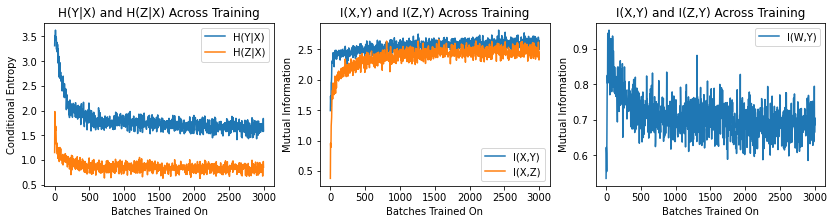

In [242]:
plt.figure(figsize=(14,3))

plt.subplot(131)
plt.plot(np.linspace(1, len(entropies_YgivenX)*c_rate, num=len(entropies_YgivenX)), entropies_YgivenX, label='H(Y|X)')
plt.plot(np.linspace(1, len(entropies_ZgivenX)*c_rate, num=len(entropies_ZgivenX)), entropies_ZgivenX, label='H(Z|X)')
plt.xlabel("Batches Trained On")
plt.ylabel("Conditional Entropy")
plt.legend()
plt.title('H(Y|X) and H(Z|X) Across Training')

plt.subplot(132)
plt.plot(np.linspace(1, len(mutuals_yx)*c_rate, num=len(mutuals_yx)), mutuals_yx, label='I(X,Y)')
plt.plot(np.linspace(1, len(mutuals_zx)*c_rate, num=len(mutuals_zx)), mutuals_zx, label='I(X,Z)')
plt.xlabel("Batches Trained On")
plt.ylabel("Mutual Information")
plt.legend()
plt.title('I(X,Y) and I(Z,Y) Across Training')

plt.subplot(133)
plt.plot(np.linspace(1, len(mutuals_yw)*c_rate, num=len(mutuals_yw)), mutuals_yw, label='I(W,Y)')

plt.xlabel("Batches Trained On")
plt.ylabel("Mutual Information")
plt.legend()
plt.title('I(X,Y)Across Training')
plt.show()


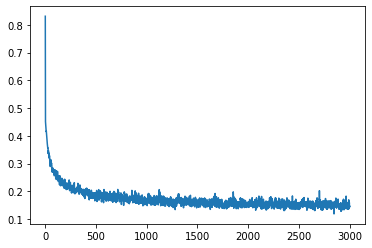

In [239]:
lossSmoothed = gaussian_filter1d(losses, sigma=3)
plt.plot(np.arange(1, len(losses)+1), losses)
plt.show()

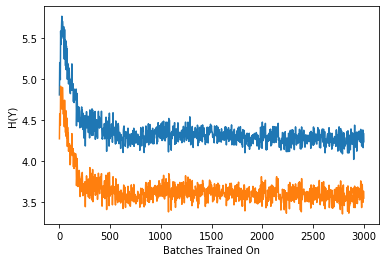

In [241]:
plt.plot(np.linspace(1, len(entropies_y)*c_rate, num=len(entropies_y)), entropies_y)
plt.plot(np.linspace(1, len(entropies_yw)*c_rate, num=len(entropies_yw)), entropies_yw, label='H(Y|X)')
plt.xlabel("Batches Trained On")
plt.ylabel("H(Y)")
plt.show()